In [2]:
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

from scipy.interpolate import interp2d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Ridge
from scipy.stats import kde

%matplotlib inline

In [3]:
#Loading data
A = scio.loadmat("tesis_cami/A.mat")["A"]
b = scio.loadmat("tesis_cami/b.mat")["b"]
XDOM = scio.loadmat("tesis_cami/XDOM.mat")["XDOM"]
YDOM = scio.loadmat("tesis_cami/YDOM.mat")["YDOM"]
ZDOM = scio.loadmat("tesis_cami/ZDOM.mat")["ZDOM"]
u = scio.loadmat("tesis_cami/u.mat")["u"]
time = scio.loadmat("tesis_cami/tiempo.mat")["tiempo"]
Su = scio.loadmat("tesis_cami/Su.mat")["Su"]
XDO = scio.loadmat("tesis_cami/XDO.mat")["XDO"]
YDO = scio.loadmat("tesis_cami/YDO.mat")["YDO"]
ZSOL = scio.loadmat("tesis_cami/ZSOL.mat")["ZSOL"]

## Tsunami Inversion (Tinti et al. 1996)

Given:
- $M$ tide-gauges
- $N$ data points (inversion time)
- $\zeta_i(t_k)$, $i = 1,\dots,M$, $k = 1,\dots,N$ the elevation at in the $i-th$ tide-gauge at time $t_k$.
- $Q$ number of grid nodes from the shallow-water equation discretization.
- $G_{kj}^i \zeta_j(t_0)$ the green function in the $i-th$ tide-gauge at time $t_k$ in the node $j$.

We want to know the initial elevation ($\zeta_j(t_0)$) at each node point $j \in Q$ at $t_0$.

To get the unkown values $\zeta_j(t_0) = w_j$, we have to solve the following equation:
\begin{align}
 A w = b
\end{align}
Where:
\begin{align}
 A = \begin{bmatrix}
    G_{11}^1 & G_{21}^1 & G_{31}^1 & \dots G_{Q1}^1 \\ 
      \vdots & & \ddots & \vdots \\
    G_{1N}^1 & G_{2N}^1 & G_{3N}^1 & \dots G_{QN}^1 \\ 
    \vdots & & \ddots & \vdots \\
    G_{11}^M & G_{21}^M & G_{31}^M & \dots G_{Q1}^M \\ 
    \vdots & & \ddots & \vdots \\
    G_{1N}^M & G_{2N}^M & G_{3N}^M & \dots G_{QN}^M \\ 
\end{bmatrix} 
 &w = \begin{bmatrix}
      w_1 \\
      w_2 \\
      \vdots \\
      w_{j-1} \\
      w_{j} \\
      w_{j+1} \\
      \vdots \\
      w_Q
\end{bmatrix} 
 & b = \begin{bmatrix}
      \zeta_1(t_1) \\
      \vdots \\
      \zeta_1(t_N) \\
      \vdots \\
      \zeta_M(t_1) \\
      \vdots \\
      \zeta_M(t_N)
\end{bmatrix} 
\end{align}
In our case:
- $i$: *Arica*, *Iquique*, *Patache*, *Mejillones*,*DART*
- $G_{kj}$ comes precalculated for the sources in *$j \in ttl?$*, we filter the time $t_1$ to $t_N$ starting from when the wave arrives to the tide gauge to the final inversion time ($N = 4\cdot t_{inversion} - t_{arrival}$).
- $w_j$ is calculated with a regularized least squared method, with tikonov regularization (Ridge Regression)

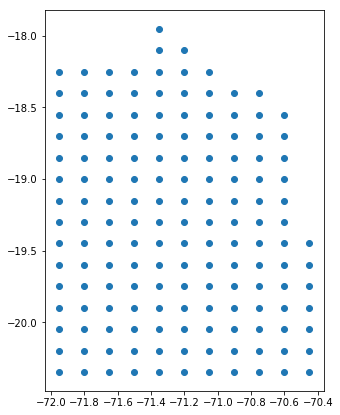

In [4]:
#Source points used
plt.figure(figsize=(5,7))
plt.scatter(u[:,0],u[:,1])

In [5]:
#Splitting data in different sensors
sensors = ["Arica","Iquique", "Patache", "Mejillones", "DART"]

# A: Source time series for each tide gauge, b: Tide gauge time series for each sensor.
#### Why 961? Nobody knows
A_arica,b_arica = A[:961],b[:961]
A_iquique,b_iquique = A[961:961*2],b[961:961*2]
A_patache,b_patache = A[961*2:961*3],b[961*2:961*3]
A_mejillones,b_mejillones = A[961*3:961*4],b[961*3:961*4]
A_dart,b_dart = A[961*4:],b[961*4:]

#Creating an array with the data separated
As = [A_arica,A_iquique,A_patache,A_mejillones,A_dart]
bs = [b_arica,b_iquique,b_patache,b_mejillones,b_dart]

#Time when data comes to the sensor
##### Where does this values come from, how we can calculate them automatically
time_offset = np.array([100,80,100,100,50]) 
##### We need to define better the inversion_time 
inversion_time = 50 

## Plotting data
After reading the data we want to visualize each $G_{kj}^i$ time series, the plots showed are the following:
- **All the data:** This contains all the data, from the earthquake itself to after the invertion time used. (**Left plot:** $G_{kj}^i$ time series, **Right:** tide-gauge sensor data)
- **Train data:** Data used for the inversion.
- **Test data:** The forecast data used to see how the model can generalize to the future values.

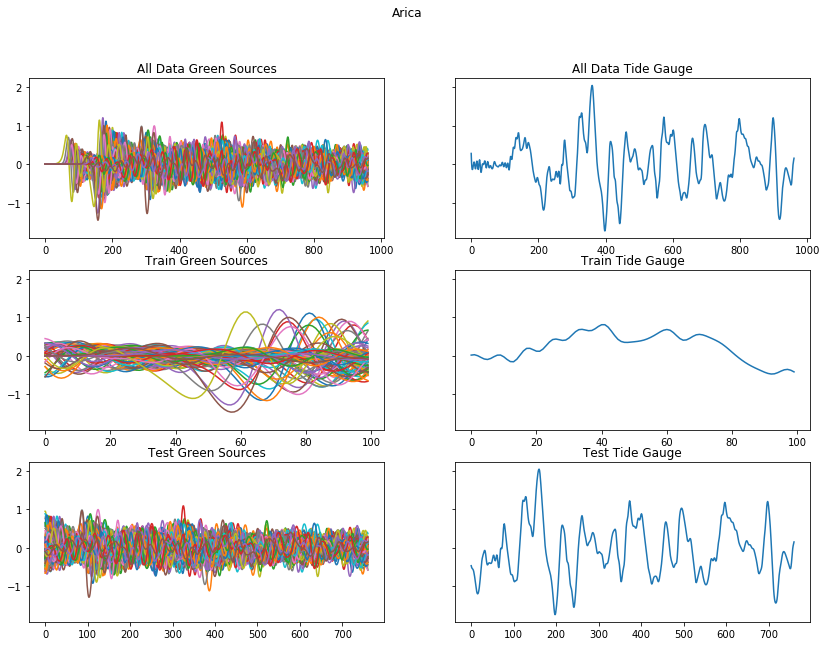

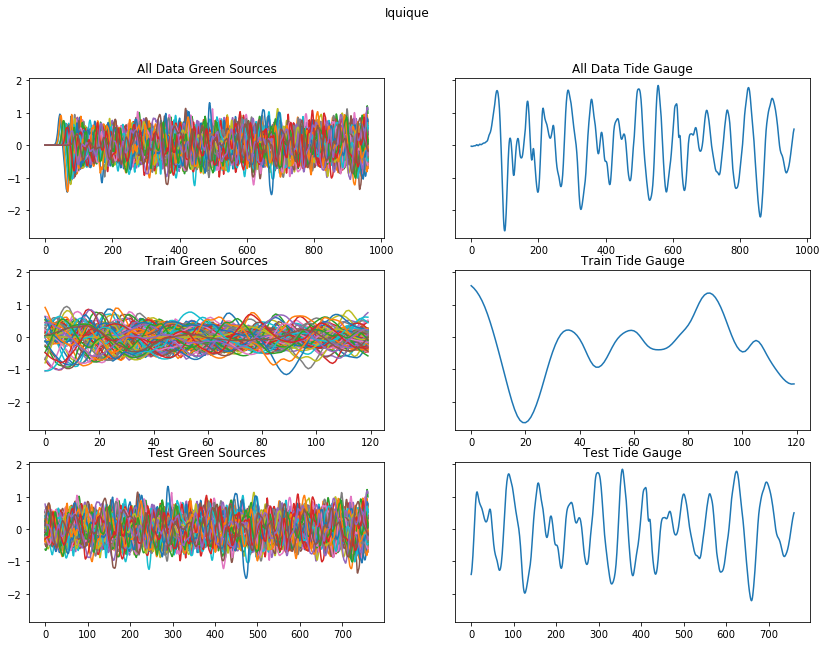

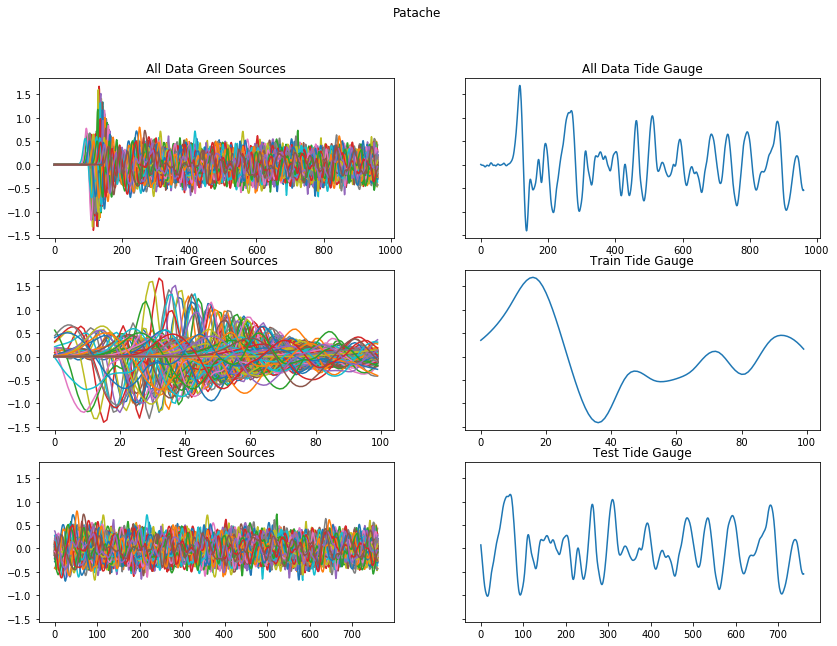

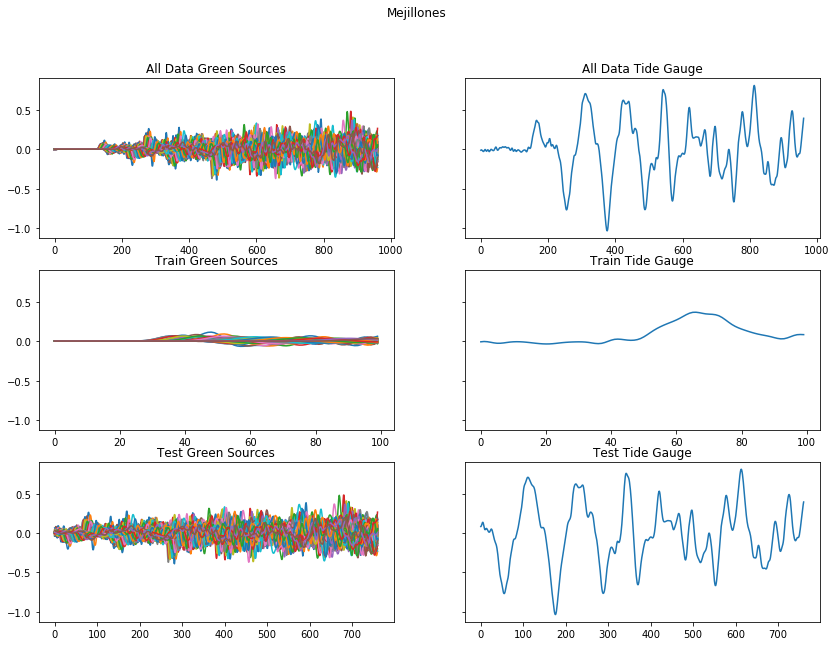

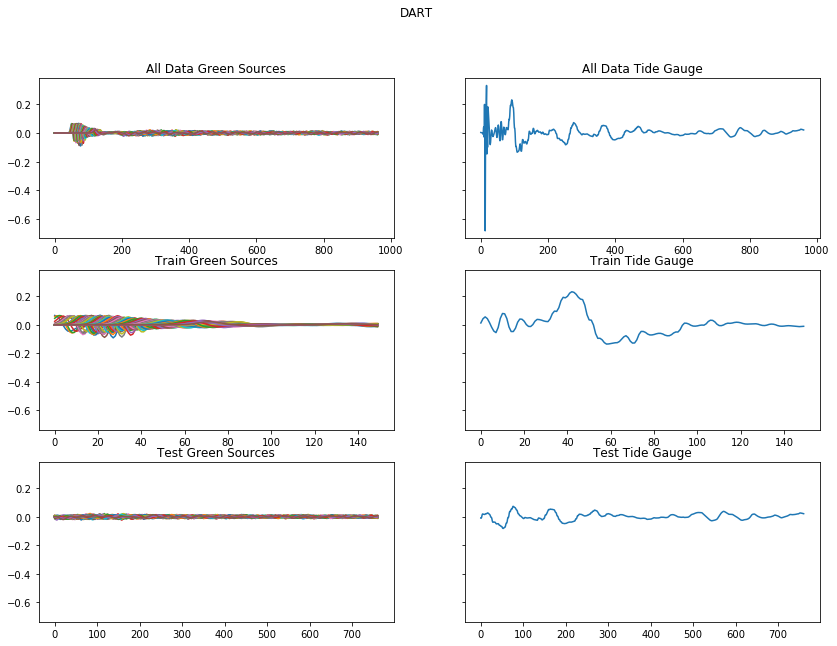

In [6]:
#Stacking all sensor data used to create the linear system
AA = []
bb = []

#Storing the values to do the inversion and forecast
AA_test = []
bb_test = []
AA_train = []
bb_train = []

for A_i,b_i,title,toffset in zip(As,bs,sensors,time_offset):
    #Getting inversion time
    start = toffset
    #### Why is the inversion time * 4??
    end = inversion_time*4 
    #Separating train with test
    AA.append(A_i[start:end])
    bb.append(b_i[start:end])

    AA_test.append(A_i[end:])
    bb_test.append(b_i[end:])
    AA_train.append(A_i[start:end])
    bb_train.append(b_i[start:end])
    
    #Plotting figures
    fig,axes = plt.subplots(3,2,figsize=(14,10),sharey=True)
    axes[0,0].plot(A_i)
    axes[0,1].plot(b_i)
    axes[0,0].set_title("All Data Green Sources")
    axes[0,1].set_title("All Data Tide Gauge")

    axes[1,0].plot(A_i[start:end])
    axes[1,1].plot(b_i[start:end])
    axes[1,0].set_title("Train Green Sources")
    axes[1,1].set_title("Train Tide Gauge")

    axes[2,0].plot(A_i[end:])
    axes[2,1].plot(b_i[end:])    
    axes[2,0].set_title("Test Green Sources")
    axes[2,1].set_title("Test Tide Gauge")
    
    fig.suptitle(title)
    plt.show()
    
#Stacking all sensor data
AA = np.vstack(AA)
bb = np.vstack(bb)

# Ridge Regression
To solve the linear equation $A w = b$ we can use a regularized least squared approach.
\begin{equation}
 w = (AA^T + \lambda I)^{-1} A^T b
\end{equation}
Where $\lambda$ is a regularization parameter, if $\lambda = 0$ is the regular leat squared solution 

In [7]:
#Calculating least square solution
reg = Ridge(alpha=3,fit_intercept=False)
reg.fit(AA,bb)

Ridge(alpha=3, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

The solution of $A w = b$ is the values of $\zeta_j(t_0)$ for each node, using this values we can visualize the initial elevation of each source point.

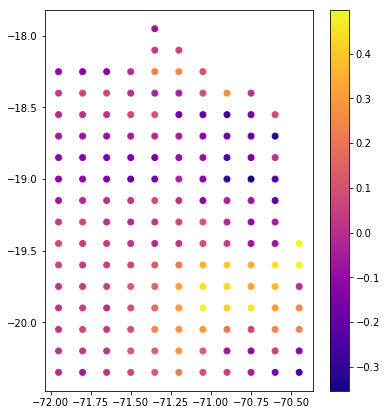

In [8]:
#Source points used
plt.figure(figsize=(6,7))
plt.scatter(u[:,0],u[:,1],c=reg.coef_,cmap="plasma")
plt.colorbar()

## Model Fit and Forecast
After we calculated the weights $w_j$, the model can be used to do forecast.

To create forecasts in $t > t_N$, given the Green Source equation in $t > t_N$ for the same $M$ tide gauges, the matrix $A^{New}$ can be created and the forecast values $b^{New}$ are calculated with:
\begin{equation}
 b^{New} = A^{New} w
\end{equation}

Measuring the quality of the model fit to the data and further forecasts, a performance metric is needed, some examples are:
- **Mean Squared Error (MSE)**
   \begin{equation}
     MSE = \frac{1}{n} \sum_{h = 0}^n \left(b_h - a_h w\right)^2
   \end{equation}
   where $b_h$ is the real value, $a_h$ is the $h-th$ row of the $A$ matrix, and $w$ is the weight vector. A **normalized** metric can be used with
   \begin{equation}
     MSPE = \frac{MSE}{\max{b_h}} 
   \end{equation}
- **Mean Absolute Error (MAE)**
   \begin{equation}
     MAE = \frac{1}{n} \sum_{h = 0}^n \left|b_h - a_h w\right|
   \end{equation} 
   And the normalized form:
   \begin{equation}
     MAPE = \frac{1}{n} \sum_{h = 0}^n \left|\frac{b_h - a_h w}{b_h}\right|
   \end{equation}    

In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

def mean_squared_percentage_error(y_true,y_pred):
    return np.mean(((y_true-y_pred)/y_true)**2)

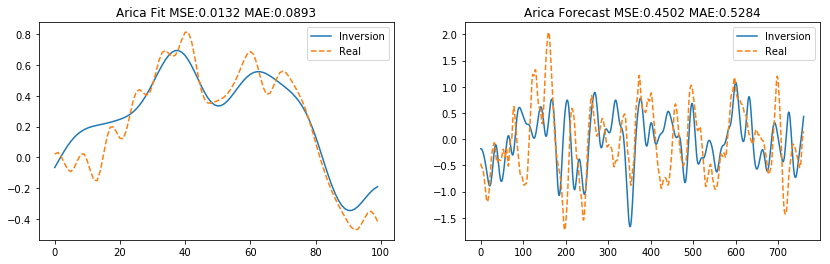

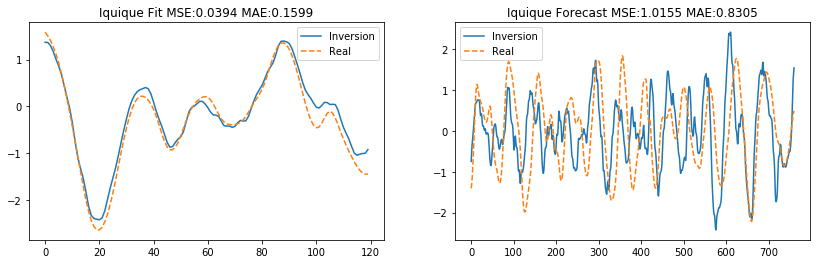

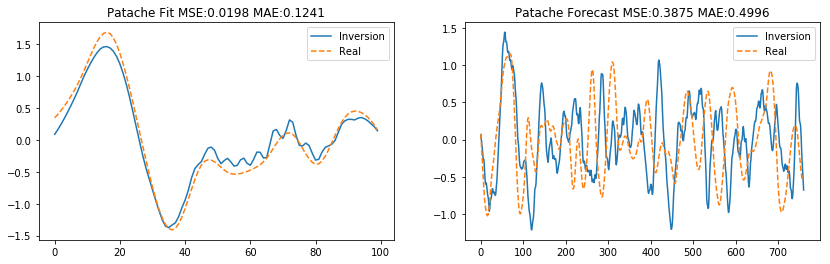

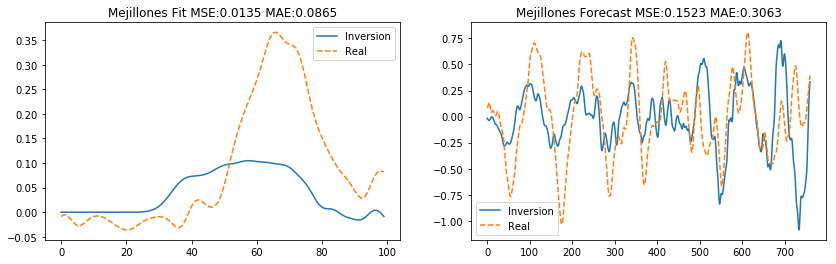

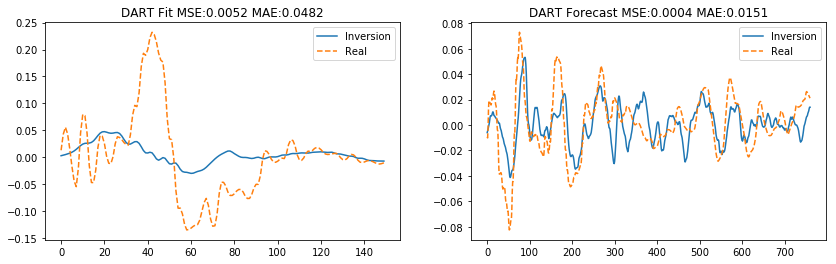

In [10]:
#Plotting solutions with rigde regression
for A_train_i, b_train_i,A_test_i, b_test_i,title in zip(AA_train,bb_train,AA_test,bb_test,sensors):
    b_pred = reg.predict(A_test_i)
    b_pred_train = reg.predict(A_train_i)
    MSE = round(metrics.mean_squared_error(b_test_i,b_pred),4)
    MAE = round(metrics.mean_absolute_error(b_test_i,b_pred),4)
    MSE_train = round(metrics.mean_squared_error(b_train_i,b_pred_train),4)
    MAE_train = round(metrics.mean_absolute_error(b_train_i,b_pred_train),4)
    
    
    fig,axes = plt.subplots(1,2,figsize=(14,4))
    axes[0].set_title("{} Fit MSE:{} MAE:{}".format(title,MSE_train, MAE_train))
    axes[0].plot(b_pred_train,label="Inversion")
    axes[0].plot(b_train_i[:,0],"--",label="Real")
    axes[0].legend()
    axes[1].set_title("{} Forecast MSE:{} MAE:{}".format(title,MSE, MAE))
    axes[1].plot(b_pred,label="Inversion")
    axes[1].plot(b_test_i[:,0],"--",label="Real")
    axes[1].legend()
    plt.show()

### References
[1] Tinti, S., A. Piatanesi, and E. Bortolucci. "The finite-element wave propagator approach and the tsunami inversion problem." Physics and Chemistry of the Earth 21.1-2 (1996): 27-32.